In [2]:
!pip install git+https://github.com/NSCC-COGS/Aestheta.git --quiet
!pip install fiona --quiet
!pip install rasterio --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 225kB 9.3MB/s 
     |████████████████████████████████| 14.8MB 271kB/s 
     |████████████████████████████████| 19.1MB 1.3MB/s 


In [4]:
!wget -O benthic_ground_truth.zip https://nscc-my.sharepoint.com/:u:/g/personal/w0001006_campus_nscc_ca/EaYM7nvthFFPm7MXx357X4UBm-xe1uGJVOOg-WpXbPeWGQ?download=1 --quiet --show-progress
!wget -O PQ_Lidar_DEMo13.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/ETLMGXbg1GpKph8-J0TNs60B-wdefo7rmRwp6FNMdkVOUw?download=1 --quiet --show-progress
!wget -O PQ_RCD_50cm_Cubic.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/EeGmrgtNc9ZErvlXcVXfNaABsgdvFf7XTX-RprngA9KaCA?download=1 --quiet --show-progress

benthic_ground_trut 100%[===================>]   4.79K  --.-KB/s    in 0s      
PQ_Lidar_DEMo13.tif 100%[===================>] 375.34M  19.0MB/s    in 20s     
PQ_RCD_50cm_Cubic.t 100%[===================>]   1.73G  47.6MB/s    in 26s     
Archive:  benthic_ground_truth.zip
caution: filename not matched:  -q


In [6]:
!unzip benthic_ground_truth.zip

Archive:  benthic_ground_truth.zip
 extracting: benthic_ground_truth.cpg  
  inflating: benthic_ground_truth.dbf  
  inflating: benthic_ground_truth.prj  
  inflating: benthic_ground_truth.sbn  
  inflating: benthic_ground_truth.sbx  
  inflating: benthic_ground_truth.shp  
  inflating: benthic_ground_truth.shx  


In [7]:
from aestheta import core
import fiona, rasterio
import rasterio.features
from matplotlib import pyplot as plt

In [9]:
vector_file = r'benthic_ground_truth.shp'
ortho_file = r'PQ_RCD_50cm_Cubic.tif'
dem_file = r'PQ_Lidar_DEMo13.tif'

In [32]:
def snap_raster(raster_file, snap_raster_file):
  #https://stackoverflow.com/questions/59102791/how-to-find-corresponding-pixels-between-two-geospatial-raster-data-with-differe

  from rasterio.warp import calculate_default_transform, reproject, Resampling

  raz = rasterio.open(raster_file)
  snp = rasterio.open(snap_raster_file)


  kwargs = raz.meta.copy()
  kwargs.update({
      'crs': snp.crs,
      'transform': snp.transform,
      'width': snp.width,
      'height': snp.height
  })

  with rasterio.open('groundtruth.tif', 'w', **kwargs) as dst:
      reproject(
          source=rasterio.band(raz, 1),
          destination=rasterio.band(dst, 1),
          src_transform=raz.transform,
          src_crs=raz.crs,
          dst_transform=snp.transform,
          dst_crs=snp.crs,
          resampling=Resampling.nearest)

In [22]:
snap_raster(dem_file,ortho_file)

62.141193


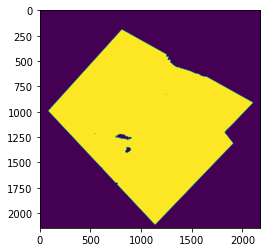

In [26]:
import imageio
dem = imageio.imread('groundtruth.tif')
print(dem.max())
plt.imshow(dem[::10,::10])
plt.show()

255


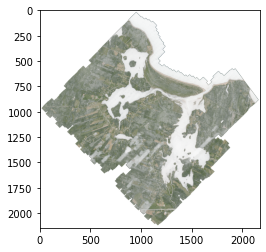

In [33]:
ortho = imageio.imread('PQ_RCD_50cm_Cubic.tif')
print(ortho.max())
plt.imshow(ortho[::10,::10])
plt.show()

In [36]:
image1 = ortho[::10,::10,0]
image2 = dem[::10,::10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.


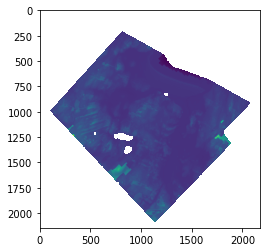

In [37]:
plt.imshow(image1 * image2)

In [11]:
def reproject(imageFile):
    '''this is a boilerplate example of how image reporjection can be done using rasterio'''
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    # dst_crs = 'EPSG:4326'
    dst_crs = 'EPSG:3857' # web mercator 

    with rasterio.open(imageFile) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open('testLandsat.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [8]:
def add_features_from_vec(raster_file , vector_file):
  src = rasterio.open(raster_file)

  shapefile = fiona.open(vector_file)
  geom = [shapes['geometry'] for shapes in shapefile]
  attrib = [shapes['properties'] for shapes in shapefile]

  image = rasterio.features.rasterize(geom, out_shape=src.shape, transform=src.transform)
  return image

In [17]:
image = add_features_from_vec(raster_file,vector_file)

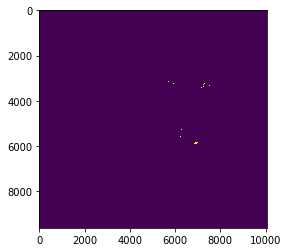

In [20]:
plt.imshow(image, interpolation='nearest')